### 1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:


Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In [12]:
import numpy as np
max_speeds = np.load('07.2data/max-speeds.npy')
years_nb = max_speeds.shape[0]


p = np.arange(1,years_nb+1)/(years_nb+1)
max_speeds = np.sort(max_speeds)

In [59]:
import scipy.interpolate as interpolate
quantile_func4 = interpolate.UnivariateSpline(x=p,y=max_speeds,k=4)
quantile_func5 = interpolate.UnivariateSpline(x=p,y=max_speeds,k=5)

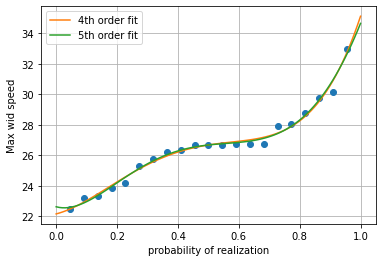

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(0,1,100)
plt.plot(p,max_speeds,marker='o',linestyle=' ')
plt.plot(X,quantile_func4(X),label="4th order fit");
plt.plot(X,quantile_func5(X),label="5th order fit");
plt.legend()
plt.grid(True)

plt.xlabel("probability of realization")
plt.ylabel("Max wid speed");

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

In [61]:
fifty_max_prob = 1. - 0.02

So the storm wind speed occurring every 50 years can be guessed as:

In [62]:
print("Estimation of max speed over a 50 year period:")
print("4th order fit estimation -->", quantile_func4(fifty_max_prob))
print("5th order fit estimation -->", quantile_func5(fifty_max_prob))

Estimation of max speed over a 50 year period:
4th order fit estimation --> 33.99121541124585
5th order fit estimation --> 33.70905320685388


Since the two values are close, one can avoid the difficult discussion of the prefreability of one fitting function over an other.

### 2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

In [84]:
months = np.arange(1,13)
T_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
T_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
print("max temperature ", T_max)
print("min temperature ", T_min)

max temperature  [17 19 21 28 33 38 37 37 31 23 19 18]
min temperature  [-62 -59 -56 -46 -32 -18  -9 -13 -25 -46 -52 -58]



* Plot these temperature extremes.

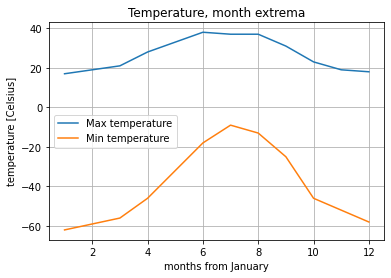

In [127]:
plt.plot(months, T_max, label="Max temperature")
plt.plot(months, T_min, label="Min temperature")

plt.title("Temperature, month extrema")
plt.ylabel("temperature [Celsius]")
plt.xlabel("months from January")
plt.legend()
plt.grid(True)


* Define a function that can describe min and max temperatures. 

The data seams to be bell-shaped. Without a background theory it is difficult to prefer one bell'shaped template function to an other.
One could use:

  1) Gaussian template: 
  $f[A,m,D,h](x) := A e^\frac{-(x-m)^2}{2D}+h $
  
  2) Lorentzian template: 
  $f[A,m,D,h](x) := A \frac{1}{1+\frac{(x-m)^2}{2D}}+h $
  
Considering the ciclical natuere of temperature one could also try fo fit with a trigonometric function, (even if no one garantees the periodic function to be a sinusoidal one actually).

  3) Trigonometric template:
  $f[A,m,D,h](x) := A \cos\big( (x-m)/D\big)+h $

* Fit this function to the data with scipy.optimize.curve_fit().

In [168]:
from scipy import optimize

f1 = lambda x,A,m,D,h : A*np.exp(-(x-m)**2/(2*D))+h
f2 = lambda x,A,m,D,h : A/(1+(x-m)**2/(2*D))+h
f3 = lambda x,A,m,D,h : A*np.cos((x-m)/(2*D))+h

In [169]:
param1_max,cov1_max = optimize.curve_fit(f1,months,T_max,p0=[20,7,1.5,15])
param2_max,cov2_max = optimize.curve_fit(f2,months,T_max,p0=[20,7,1.5,15])
param3_max,cov3_max = optimize.curve_fit(f3,months,T_max,p0=[20,7,1.5,15])
param1_min,cov1_min = optimize.curve_fit(f1,months,T_min,p0=[50,7,1.5,-60])
param2_min,cov2_min = optimize.curve_fit(f2,months,T_min,p0=[50,7,1.5,-60])
param3_min,cov3_min = optimize.curve_fit(f3,months,T_min,p0=[50,7,1.5,-60])


* Plot the result. Is the fit reasonable? If not, why?

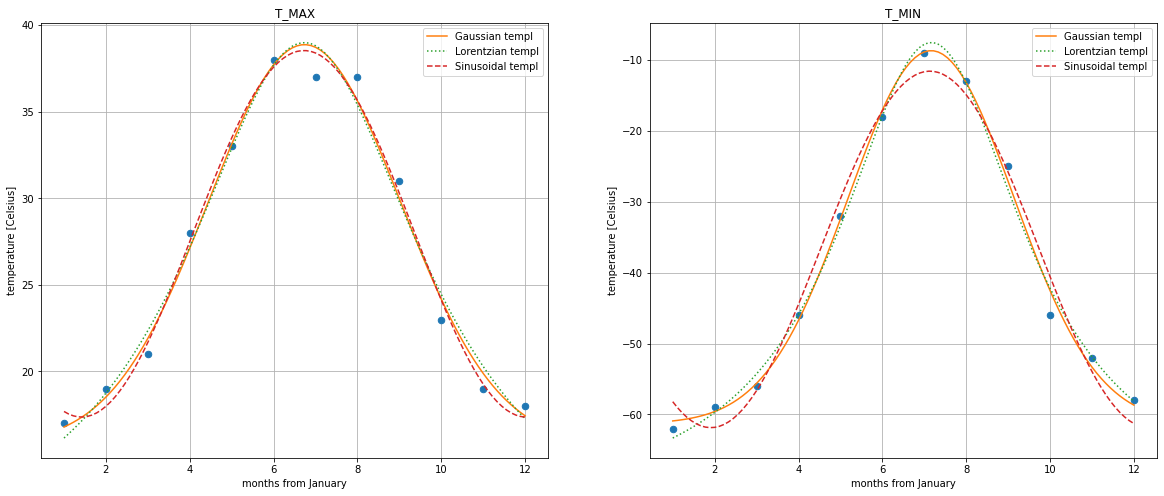

In [170]:
fig = plt.figure(figsize=[20,8])

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

months_fine = np.linspace(1,12,100)

ax1.set_title("T_MAX")
ax1.plot(months,T_max,marker='.',markersize=13,linestyle='')
ax1.plot(months_fine,f1(months_fine,*param1_max),linestyle='-',label="Gaussian templ")
ax1.plot(months_fine,f2(months_fine,*param2_max),linestyle=':',label="Lorentzian templ")
ax1.plot(months_fine,f3(months_fine,*param3_max),linestyle='--',label="Sinusoidal templ")
ax1.set_ylabel("temperature [Celsius]")
ax1.set_xlabel("months from January")
ax1.legend()
ax1.grid(True)

ax2.set_title("T_MIN")
ax2.plot(months,T_min,marker='.',markersize=13,linestyle='')
ax2.plot(months_fine,f1(months_fine,*param1_min),linestyle='-',label="Gaussian templ")
ax2.plot(months_fine,f2(months_fine,*param2_min),linestyle=':',label="Lorentzian templ")
ax2.plot(months_fine,f3(months_fine,*param3_min),linestyle='--',label="Sinusoidal templ")
ax2.set_ylabel("temperature [Celsius]")
ax2.set_xlabel("months from January")
ax2.legend()
ax2.grid(True)

plt.show()

For the MAX case, the tre template functions chosen produce almost identical results for the central part of the time series. The fringes points seems to be marginally better described by the Sinusoidal function.

For the MIN case, the Gaussian and Lorentzian function give equivalent results and fit well the curve over all time span. Sinusoidal template has some difficulties in fititing the max and the fringes. Seems that the Sinusoidal template is not peaked enough. Using a sinusoidal to the forth power template solves this problem and produces a good fit.

* Is the time offset for min and max temperatures the same within the fit accuracy?

In [189]:
print("<<MAX>>","\t1) m={:.3f} pm {:.3f}".format(param1_max[1],np.sqrt(cov1_max[1,1])),"\t\t2) m={:.3f} pm {:.3f}".format(param2_max[1],np.sqrt(cov2_max[1,1])),"\t3) m={:.3f} pm {:.3f}".format(param3_max[1],np.sqrt(cov3_max[1,1])))
print("<<MIN>>","\t1) m={:.3f} pm {:.3f}".format(param1_min[1],np.sqrt(cov1_min[1,1])),"\t\t2) m={:.3f} pm {:.3f}".format(param2_min[1],np.sqrt(cov2_min[1,1])),"\t3) m={:.3f} pm {:.3f}".format(param3_min[1],np.sqrt(cov3_min[1,1])))

<<MAX>> 	1) m=6.736 pm 0.079 		2) m=6.732 pm 0.095 	3) m=6.723 pm 0.072
<<MIN>> 	1) m=7.165 pm 0.047 		2) m=7.168 pm 0.059 	3) m=7.133 pm 0.095


The the peackposition of the max and min series is registered as *different* in all of the fits tested. All the fits agrees with each others within the estimation error.

### 3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


In [180]:
help("string".format)

Help on built-in function format:

format(...) method of builtins.str instance
    S.format(*args, **kwargs) -> str
    
    Return a formatted version of S, using substitutions from args and kwargs.
    The substitutions are identified by braces ('{' and '}').



### 4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

### 5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.